In [1]:
%matplotlib nbagg

Prototype code to calculate fluctuation EM and radial binning efficiently.

In [178]:
import functools
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import sparse
import numba
import scipy.sparse

from libertem.udf import UDF
import libertem.analysis.gridmatching as grm
import libertem.api as lt

In [59]:
d = np.arange(0, 10, 0.01)
fy, fx = (512, 512)

In [180]:
def weight_smooth(r0, r):
    diff = np.abs(r - r0)
    return np.maximum(0, 1 - diff)

def weight_hard(r0, r):
    return np.abs(r-r0) <= 0.5

<IPython.core.display.Javascript object>


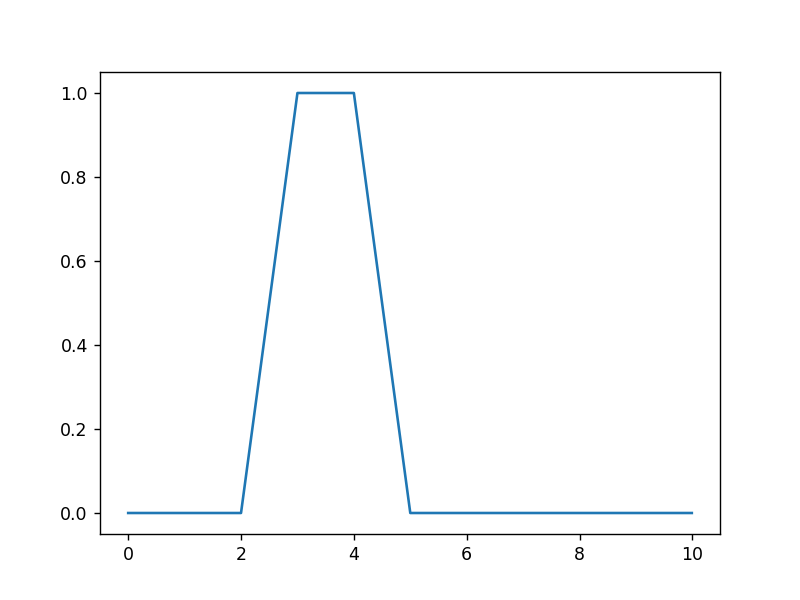

In [181]:
fix, axes = plt.subplots()
plt.plot(d, weight_smooth(3, d) + weight_smooth(4, d))

<IPython.core.display.Javascript object>


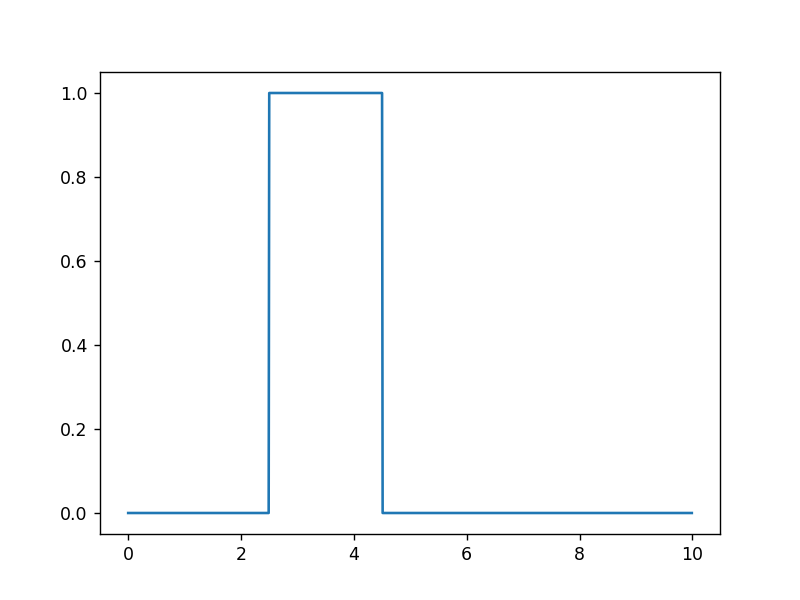

In [6]:
fix, axes = plt.subplots()
plt.plot(d, weight_hard(3, d) + weight_hard(4, d))

In [162]:
y, x = np.ogrid[0:fy, 0:fx]

In [60]:
cy, cx = (fy//2-0.5, fx//2-0.5)

In [164]:
r = np.sqrt((y - cy)**2 + (x - cx)**2)

<IPython.core.display.Javascript object>


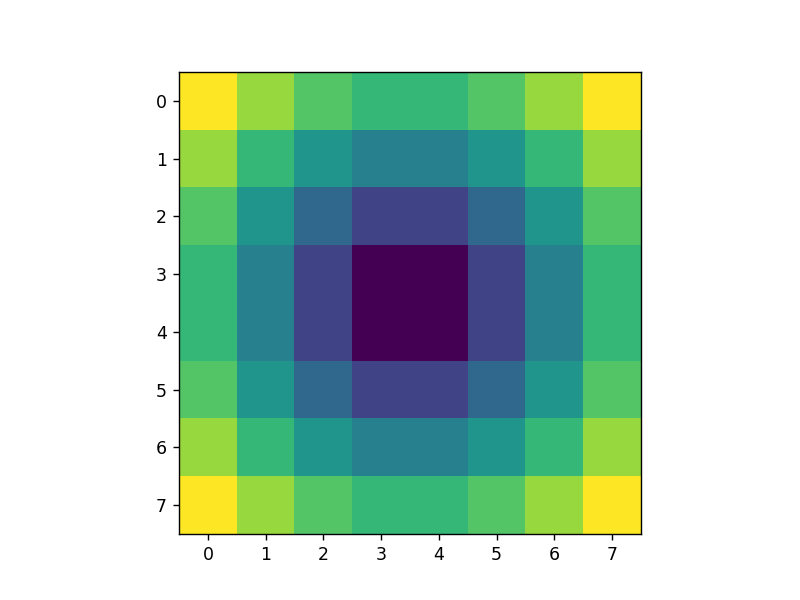

In [144]:
fix, axes = plt.subplots()
plt.imshow(r)

In [165]:
n_bins = int(np.ceil(np.max(r))) + 1

In [166]:
n_bins

363

In [3]:
@numba.njit
def _dot(values, iis, data, res):
    # Magic number 32: This is the smallest number where overheads
    # did not have an impact on the performance
    j_block_size = 32
    j_blocks = data.shape[0] // j_block_size
    j_remainder = data.shape[0] % j_block_size
    # The blocking helps to keep iis and values in the cache for
    # the j range that is being processed
    for j_block in range(j_blocks):
        for idx in range(values.shape[0]):
            # This is also values.shape[1]
            for j in range(j_block*j_block_size, (j_block + 1)*j_block_size):
                i = iis[idx, j]
                v = values[idx, j]
                for k in range(data.shape[1]):
                    # FIXME sum is not numerically stable
                    # That should be tolerable if the matrix is sparse, i.e. there aren't many summands
                    # Stable implementation may require an intermediate buffer
                    res[i, k] += data[j, k] * v
    for idx in range(values.shape[0]):
        # This is also values.shape[1]
        for j in range(j_blocks*j_block_size, j_blocks*j_block_size + j_remainder):
            i = iis[idx, j]
            v = values[idx, j]
            for k in range(data.shape[1]):
                # FIXME sum is not numerically stable
                # That should be tolerable if the matrix is sparse, i.e. there aren't many summands
                # Stable implementation may require an intermediate buffer
                res[i, k] += data[j, k] * v
                
@numba.njit
def _transposed_left_dot(data, values, iis, res):
    '''
    This function performs dot(data, masks.T, i.e. a per-frame masked sum of data, 
    with an optimized access pattern. This matches the way how data and mask are "naturally"
    stored and handled in LiberTEM
    '''
    # Magic number 32: This is the smallest number where overheads
    # did not have an impact on the performance
    j_block_size = 32
    j_blocks = data.shape[1] // j_block_size
    j_remainder = data.shape[1] % j_block_size
    # The blocking helps to keep iis and values in the cache for
    # the j range that is being processed
    for j_block in range(j_blocks):
        for idx in range(values.shape[0]):
            for j in range(j_block*j_block_size, (j_block + 1)*j_block_size):
                i = iis[idx, j]
                v = values[idx, j]
                for k in range(data.shape[0]):
                    # FIXME sum is not numerically stable
                    # That should be tolerable if the matrix is sparse, i.e. there aren't many summands
                    # Stable implementation may require an intermediate buffer
                    res[k, i] += data[k, j] * v
    for idx in range(values.shape[0]):
        for j in range(j_blocks*j_block_size, j_blocks*j_block_size + j_remainder):
            i = iis[idx, j]
            v = values[idx, j]
            for k in range(data.shape[0]):
                # FIXME sum is not numerically stable
                # That should be tolerable if the matrix is sparse, i.e. there aren't many summands
                # Stable implementation may require an intermediate buffer
                res[k, i] += data[k, j] * v

@numba.njit
def _binned_std(data, values, iis, max_i, fill):
    '''
    This function performs binned std calculation within the weighed bins given my the sparse matrix
    with an optimized
    access pattern. This matches the way how data and mask are "naturally"
    stored and handled in LiberTEM
    '''
    data = data.reshape((-1, values.shape[1]))
    pixelsums = np.zeros((1, max_i))
    average = np.zeros((data.shape[0], max_i))
    std = np.zeros((data.shape[0], max_i))
    
    _transposed_left_dot(np.ones((1, values.shape[1])), values, iis, pixelsums)
    _transposed_left_dot(data, values, iis, average)
    
    pixelsums = pixelsums.flatten()
    
    select = (pixelsums != 0)
    
    average[:, select] /= pixelsums[select]
    
    
    # Magic number FIXME: This is the smallest number where overheads
    # did not have an impact on the performance
    j_block_size = 32
    j_blocks = data.shape[1] // j_block_size
    j_remainder = data.shape[1] % j_block_size
    # The blocking helps to keep iis and values in the cache for
    # the j range that is being processed
    for j_block in range(j_blocks):
        for idx in range(values.shape[0]):
            for j in range(j_block*j_block_size, (j_block + 1)*j_block_size):
                i = iis[idx, j]
                v = values[idx, j]
                for k in range(data.shape[0]):
                    # FIXME sum is not numerically stable
                    # That should be tolerable if the matrix is sparse, i.e. there aren't many summands
                    # Stable implementation may require an intermediate buffer
                    std[k, i] += (data[k, j] - average[k, i])**2 * v
    for idx in range(values.shape[0]):
        for j in range(j_blocks*j_block_size, j_blocks*j_block_size + j_remainder):
            i = iis[idx, j]
            v = values[idx, j]
            for k in range(data.shape[0]):
                # FIXME sum is not numerically stable
                # That should be tolerable if the matrix is sparse, i.e. there aren't many summands
                # Stable implementation may require an intermediate buffer
                std[k, i] += (data[k, j] - average[k, i])**2 * v
                
    std[:, select] /= pixelsums[select]
    std[:, np.invert(select)] = fill
    average[:, np.invert(select)] = fill
    return np.sqrt(std), average
    
                
# Necessary for inlining in Nopython mode
@numba.njit
def _add_index_depth(values, iis, n):
    iis = np.concatenate((iis, np.zeros((n, iis.shape[1]), dtype=iis.dtype)), axis=0)
    values = np.concatenate((values, np.zeros((n, values.shape[1]), dtype=values.dtype)), axis=0)
    return (values, iis)
                
@numba.njit                                
def _set_coords(new_iis, new_jjs, new_vals, indices, iis, values):
    for k in range(len(new_iis)):
        i = new_iis[k]
        j = new_jjs[k]
        idx = 0
        new = True
        for idx in range(indices[j]):
            if iis[idx, j] == i and values[idx, j] != 0:
                new = False
                break
        # was unset and remains unset
        if new and new_vals[k] == 0:
            continue
        if new:
            idx += 1
        if values.shape[0] <= idx:
            (values, iis) = _add_index_depth(values, iis, n=idx - values.shape[0] + 1)

        iis[idx, j] = i
        values[idx, j] = new_vals[k]
        if new:
            indices[j] = idx + 1
    return (indices, iis, values)


@numba.njit
def _todense(shape, iis, values):
    res = np.zeros(shape=shape, dtype=values.dtype)
    for j in range(iis.shape[1]):
        for idx in range(iis.shape[0]):
            i = iis[idx, j]
            v = values[idx, j]
            if v != 0:
                res[i, j] = v
    return res

class PaddedCSCMatrix(object):
    
    def __init__(self, shape, dtype, indices, values, iis):
        self._shape = shape
        self._dtype = dtype
        self._indices = indices
        self._values = values
        self._iis = iis
    
    @classmethod
    def from_numpy(cls, matrix):
        '''
        For simplicity, only support m x n matrices for now
        '''
        assert len(matrix.shape) == 2        
        shape = matrix.shape
        dtype = matrix.dtype
        (i, j) = np.mgrid[0:matrix.shape[0], 0:matrix.shape[1]]
        non_zero = (matrix != 0)
        depth = np.max(non_zero.astype(np.int64).sum(axis=0))

        m = cls.zeros(shape=shape, dtype=dtype, depth=depth)
        m.set_coords(i[non_zero], j[non_zero], matrix[non_zero])              
        return m
    
    @classmethod
    def from_sparse(cls, sp):
        non_zero = (sp != 0)
        depth = np.max(non_zero.astype(np.int64).sum(axis=0))
        m = cls.zeros(shape=sp.shape, dtype=sp.dtype, depth=depth)
        m.set_coords(*sp.coords, vals=sp.data)
        return m
                    
    @classmethod
    def zeros(cls, shape, dtype=np.float64, depth=0):
        assert len(shape) == 2
        dtype = np.dtype(dtype)
        
        indices = np.zeros(shape[1], dtype=np.int64)
        values = np.zeros((depth, shape[1]), dtype=dtype)
        iis = np.zeros((depth, shape[1]), dtype=np.int64)
        
        return cls(shape, dtype, indices, values, iis)
                    
    def __getitem__(self, idx):
        i, j = idx
        idx = np.where(self._iis[:, j] == i)
        if idx:
            return self._values[idx, j]
        else:
            return 0
        
    def set_layer(self, i, mask):
        non_zero = mask != 0
        jj = np.arange(self._shape[1], dtype=np.int64)
        ii = i*np.ones(self._shape[1], dtype=np.int64)
        self.set_coords(iis=ii[non_zero], jjs=jj[non_zero], vals=mask[non_zero])
    
    def set_coords(self, iis, jjs, vals):
        (self._indices, self._iis, self._values) = _set_coords(
            new_iis=iis, new_jjs=jjs, new_vals=vals,
            indices=self._indices, iis=self._iis, values=self._values
        )        
    
    def __setitem__(self, idx, value):
        i, j = idx
        self.set_coords([i], [j], [value])

    def add_index_depth(self, n=1):
        (self._values, self._iis) = _add_index_depth(self._values, self._iis, n)

    def dot(self, data):
        assert data.shape[0] == self._shape[1]
        res = np.zeros((self._shape[0], data.shape[1]), dtype=np.float64)
        _dot(values=self._values, iis=self._iis, data=data, res=res)
        return res
    
    def transposed_left_dot(self, data):
        assert data.shape[1] == self._shape[1]
        res = np.zeros((data.shape[0], self._shape[0]), dtype=np.float64)
        _transposed_left_dot(data=data, values=self._values, iis=self._iis, res=res)
        return res
    
    def binned_std(self, data):
        return _binned_std(data=data, values=self._values, iis=self._iis, max_i= self._shape[0], fill=np.float64('nan'))
    
    def todense(self):
        return _todense(self._shape, self._iis, self._values)
    
    def tosparse(self):
        nonzero = self._values != 0
        iis = self._iis[nonzero]
        row = np.arange(self._shape[1], dtype=np.int64)
        jjs = np.tile(row, (self._iis.shape[0], 1))[nonzero]
        return sparse.COO(coords=(iis, jjs), data=self._values[nonzero], shape=self._shape)
    
    def tocsr(self):
        nonzero = self._values != 0
        iis = self._iis[nonzero]
        row = np.arange(self._shape[1], dtype=np.int64)
        jjs = np.tile(row, (self._iis.shape[0], 1))[nonzero]
        return scipy.sparse.csr_matrix((self._values[nonzero], (iis, jjs)), shape=self._shape)

    @property
    def shape(self):
        return self._shape
    
    @property
    def dtype(self):
        return self._dtype
    
    @property 
    def depth(self):
        return self._iis.shape[0]

In [167]:
rings = PaddedCSCMatrix.zeros((n_bins, fy * fx))
rr = r.flatten()
jjs = np.arange(len(rr), dtype=np.int64)
for r0 in range(n_bins):
    diff = np.abs(rr - r0)
    vals = np.maximum(0, 1 - diff)
    select = vals != 0
    rings.set_coords(
        iis=r0 * np.ones(np.count_nonzero(select), dtype=np.int64),
        jjs=jjs[select],
        vals=vals[select],
    )

In [168]:
data = np.zeros((3, fy, fx))

In [169]:
data[0] = 1

In [170]:
data[1, 0:fy//2, 0:fx//2] = 1

In [171]:
data[2, fy//4:fy//4*3, fx//4:fx//4*3] = 1

In [172]:
sparse_rings = rings.tosparse()

In [173]:
(std, avg) = rings.binned_std(data)
print(std)
print(avg)

[[0.        0.        0.        ... 0.        0.        0.       ]
 [0.4330127 0.4330127 0.4330127 ... 0.4330127 0.4330127 0.4330127]
 [0.        0.        0.        ... 0.        0.        0.       ]]
[[1.   1.   1.   ... 1.   1.   1.  ]
 [0.25 0.25 0.25 ... 0.25 0.25 0.25]
 [1.   1.   1.   ... 0.   0.   0.  ]]


In [174]:
%timeit rings.binned_std(data)

31.9 ms ± 631 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [115]:
def polar_map(fy, fx, cy, cx):
    y, x = np.mgrid[0:fy, 0:fx]
    dy = y - cy
    dx = x - cx
    dy = dy.flatten()
    dx = dx.flatten()
    cartesians = np.stack((dy, dx)).T
    polars = grm.make_polar(cartesians)
    return (polars[:, 0].reshape((fy, fx)), polars[:, 1].reshape((fy, fx)))
    

In [65]:
def binning_rings(fy, fx, cy, cx, rad_in=0, rad_out=None):
    if rad_out is None:
        dy = max(cy, fy - cy)
        dx = max(cx, fx - cx)
        rad_out = np.sqrt(dy**2 + dx**2)
    
    rad_in = int(np.floor(rad_in))
    rad_out = int(np.ceil(rad_out))
        
    y, x = np.ogrid[0:fy, 0:fx]
    r = np.sqrt((y - cy)**2 + (x - cx)**2)
    r = r.flatten()
    
    shape = (rad_out - rad_in, fy*fx)
    slices = []
    
    jjs = np.arange(len(r), dtype=np.int64)

    for r0 in range(rad_in, rad_out):
        diff = np.abs(r - r0)
        vals = np.maximum(0, 1 - diff)
        select = vals != 0
        slices.append(sparse.COO(shape=shape[1], data=vals[select], coords=(jjs[select],)))
    return sparse.stack(slices)

<IPython.core.display.Javascript object>


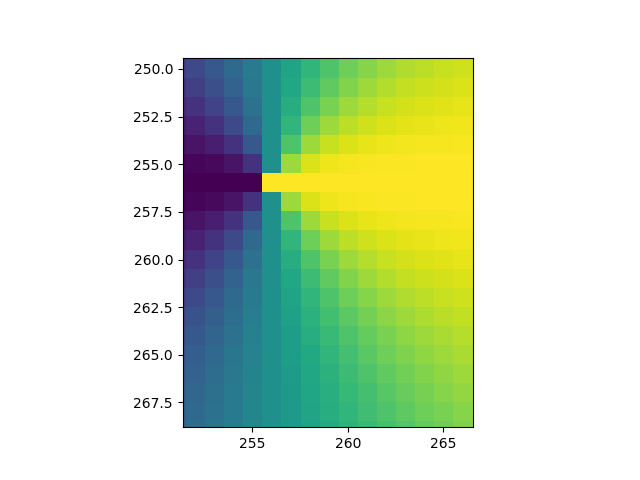

In [116]:
fig, axes = plt.subplots()
r, phi = polar_map(512, 512, 256, 256)
plt.imshow(np.cos(phi))

In [77]:
class BinnedStdUDF(UDF):
    def get_result_buffers(self):
        return {
            'average': self.buffer(
                kind="nav", extra_shape=(self.params.n_bins, ), dtype="float32"
            ),
            'std': self.buffer(
                kind="nav", extra_shape=(self.params.n_bins, ), dtype="float32"
            ),

        }

    def get_task_data(self, meta):   
        if callable(self.params.bins):
            bins = self.params.bins()
        else:
            bins = self.params.bins
        bins = PaddedCSCMatrix.from_sparse(bins.reshape((bins.shape[0], -1)))
        kwargs = {
            'bins': bins,
        }
        return kwargs

    def process_frame(self, frame):
        frame = frame.reshape((1, -1))
        average, std = self.task_data.bins.binned_std(frame)
        self.results.average[:] = average.flatten()
        self.results.std[:] = std.flatten()
    
def run_std(ctx, dataset, bins, n_bins=None, roi=None):
    """
    Return a standard deviation(SD) value for each frame of pixels which belong to ring mask.
    Parameters
    ----------
    ctx: Context
        Context class that contains methods for loading datasets,
        creating jobs on them and running them

    dataset: DataSet
        A dataset with 1- or 2-D scan dimensions and 2-D frame dimensions

    center: tuple
        (x,y) - coordinates of a center of a ring for a masking region of interest to calculate SD

    rad_in: int
        Inner radius of a ring mask

    rad_out: int
        Outer radius of a ring mask

    Returns
    -------
    pass_results: dict
        Returns a standard deviation(SD) value for each frame of pixels which belong to ring mask.
        To return 2-D array use pass_results['intensity'].data

    """
    if n_bins is None:
        if callable(bins):
            raise ValueError("If `bins`is callable, n_bins has to be set to the number of bins.")
        else:
            n_bins = bins.shape[0]
    udf = BinnedStdUDF(bins=bins, n_bins=n_bins)
    
    pass_results = ctx.run_udf(dataset=dataset, udf=udf, roi=roi)
    return pass_results


In [78]:
ctx = lt.Context()

In [79]:
ds = ctx.load('MIB', path=r'C:\Users\weber\Nextcloud\Projects\Open Pixelated STEM framework\Data\hdu\2019-03-28-as spun\001\20190328 151006/default.hdr')

In [7]:
roi = np.zeros(tuple(ds.shape.nav), dtype=bool)

In [29]:
roi[:] = True

In [69]:
cy, cx = (129, 134)

In [70]:
fy, fx = ds.shape.sig

In [73]:
bins = binning_rings(fy=fy, fx=fx, cy=cy, cx=cx, rad_in=0, rad_out=50)

In [122]:
r, phi = polar_map(fy=fy, fx=fx, cy=cy, cx=cx)
r = r.flatten()
phi = phi.flatten()
sin_rings_1 = bins * np.sin(phi)
cos_rings_1 = bins * np.cos(phi)
sin_rings_2 = bins * np.sin(2*phi)
cos_rings_2 = bins * np.cos(2*phi)
sin_rings_3 = bins * np.sin(3*phi)
cos_rings_3 = bins * np.cos(3*phi)
sin_rings_4 = bins * np.sin(4*phi)
cos_rings_4 = bins * np.cos(4*phi)
sin_rings_6 = bins * np.sin(6*phi)
cos_rings_6 = bins * np.cos(6*phi)

In [80]:
res = run_std(ctx, ds, bins=bins, roi=roi)

In [82]:
res.std.shape

(65536, 50)

<IPython.core.display.Javascript object>


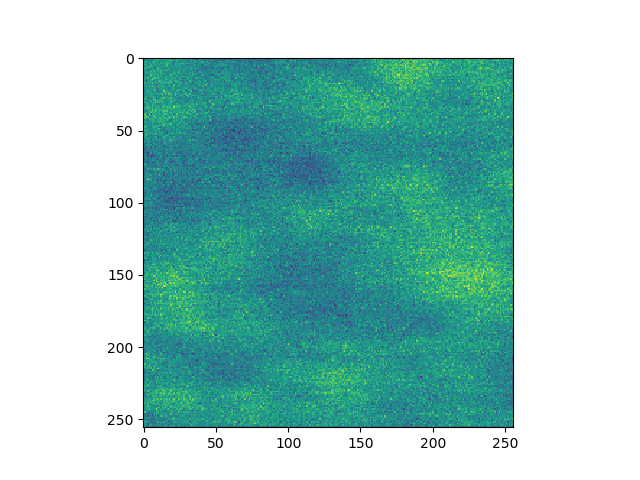

In [83]:
fig, axes = plt.subplots()

summed_std = np.sum(res.std[:, 30:34], axis=1).reshape(tuple(ds.shape.nav))
summed_avg = np.sum(res.average[:, 30:3], axis=1).reshape(tuple(ds.shape.nav))

plt.imshow(summed_std)
plt.savefig('std_map.png')

In [39]:
y_max, x_max = np.unravel_index(np.argmax(summed_std), summed_std.shape)

In [84]:
y_min, x_min = np.unravel_index(np.argmin(summed_std), summed_std.shape)

<IPython.core.display.Javascript object>


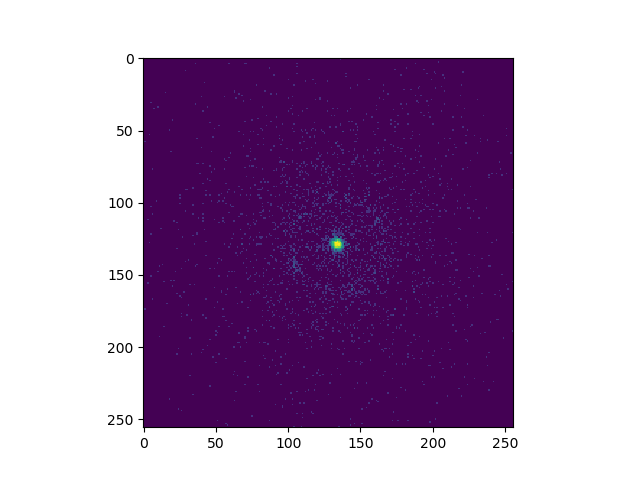

In [85]:
fig, axes = plt.subplots()
f_max = ctx.run(ctx.create_pick_analysis(ds, y=y_max, x=x_max))

plt.imshow(np.log(f_max.intensity.raw_data + 1))
plt.savefig('max_frame-y%s-x%s.png' % (y_max, x_max))

<IPython.core.display.Javascript object>


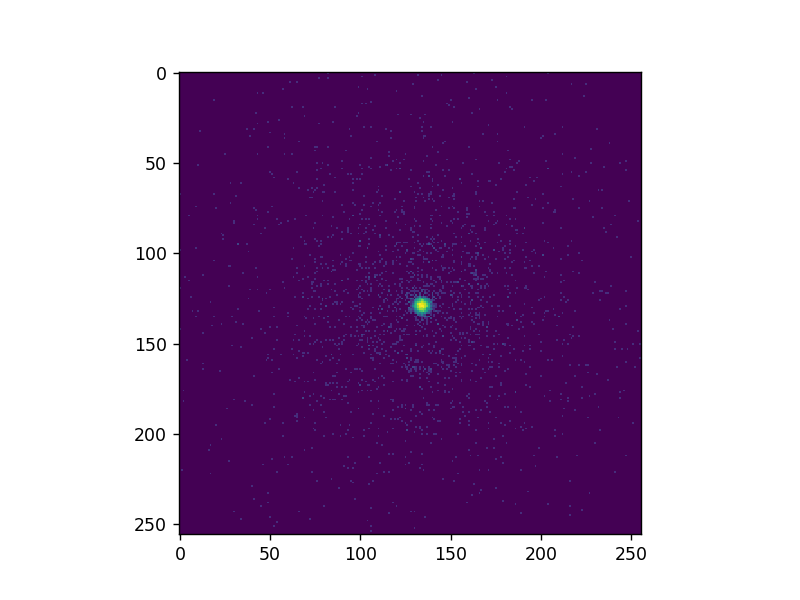

In [54]:
fig, axes = plt.subplots()
f_min = ctx.run(ctx.create_pick_analysis(ds, y=y_min, x=x_min))

plt.imshow(np.log(f_min.intensity.raw_data + 1))
plt.savefig('min_frame-y%s-x%s.png' % (y_min, x_min))

<IPython.core.display.Javascript object>


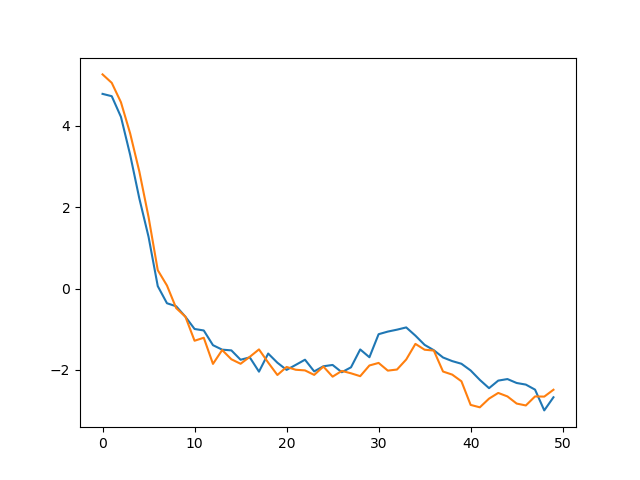

In [86]:
fig, axes = plt.subplots()

plt.plot(np.log(res.std[np.argmax(summed_std)]))
plt.plot(np.log(res.std[np.argmin(summed_std)]))

plt.savefig('compare std profile of min and max frame.png')

<IPython.core.display.Javascript object>


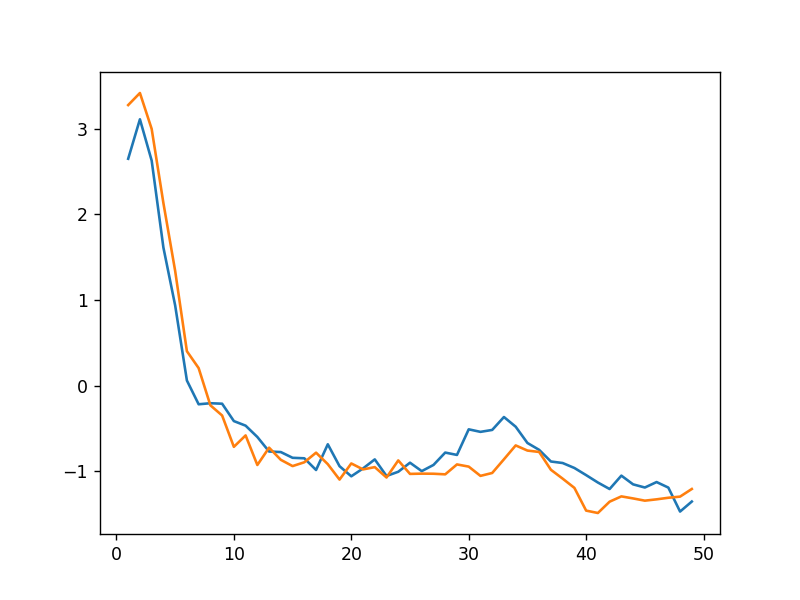

c:\users\weber\appdata\local\conda\conda\envs\libertem\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\weber\appdata\local\conda\conda\envs\libertem\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


In [56]:
fig, axes = plt.subplots()

plt.plot(np.log(res.average[np.argmax(summed_std)]))
plt.plot(np.log(res.average[np.argmin(summed_std)]))

plt.savefig('compare average profile of min and max frame.png')

In [154]:
def masks():
    m= sparse.concatenate(
        [bins,
        sin_rings_1,
        cos_rings_1,
        sin_rings_2,
        cos_rings_2,
        sin_rings_3,
        cos_rings_3,
        sin_rings_4,
        cos_rings_4,
        sin_rings_6,
        cos_rings_6]
    )
    return m.reshape((-1, fy, fx))

In [157]:
lockin_job = ctx.create_mask_job(dataset=ds, factories=masks, length=550)

In [158]:
lockin_result = ctx.run(lockin_job)

In [160]:
data = lockin_result[50:,:].reshape((5, 2, 50, fy, fx))
ref = lockin_result[0:50,:].reshape((50, fy, fx))

<IPython.core.display.Javascript object>


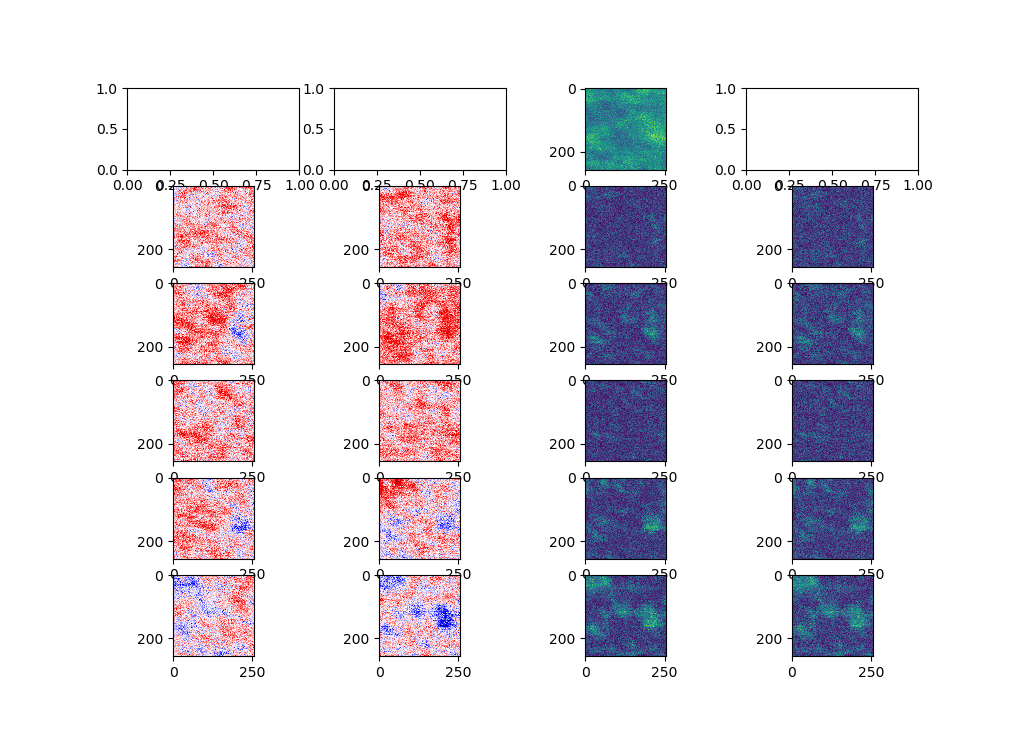

In [179]:
fig, axes = plt.subplots(nrows=6, ncols=4)
reference = np.sum(ref[30:35, :, :], axis=0)
temp_sin = np.sum(data[:, 0, 30:35, :, :], axis=1)
temp_cos = np.sum(data[:, 1, 30:35, :, :], axis=1)
intensity = np.sqrt(temp_sin**2 + temp_cos**2)
normalized = np.sqrt((temp_sin**2 + temp_cos**2) / reference**2)

ang_min = min(np.min(temp_sin), np.min(temp_cos))
ang_max = max(np.max(temp_sin), np.max(temp_cos))
abs_min = np.min(intensity)
abs_max = np.max(intensity)
rel_min = np.min(normalized)
rel_max = np.max(normalized)
axes[0,2].imshow(reference)
for row in range(5):
    axes[row+1, 0].imshow(temp_sin[row], vmin=ang_min, vmax=ang_max, cmap=cm.seismic)
    axes[row+1, 1].imshow(temp_cos[row], vmin=ang_min, vmax=ang_max, cmap=cm.seismic)
    axes[row+1, 2].imshow(intensity[row], vmin=abs_min, vmax=abs_max)
    axes[row+1, 3].imshow(normalized[row], vmin=rel_min, vmax=rel_max)

In [180]:
fig.savefig('symmetry analysis.svg')